In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
file_path = "C:\\Users\\ChazinBrahma\\Downloads\\archive (30)\\bank.csv"
df = pd.read_csv(file_path)

In [6]:
def explore_data(data):
    print("Data Shape (Rows, Columns):", data.shape)
    print("\nColumn Info:\n")
    print(data.info())
    print("\nHead of Data:\n")
    print(data.head())
    print("\nSummary Statistics:\n")
    print(data.describe())
    print("\nMissing Values per Column:\n")
    print(data.isnull().sum())

explore_data(df)

Data Shape (Rows, Columns): (11162, 17)

Column Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None

Head of Data:

   age         job  mar

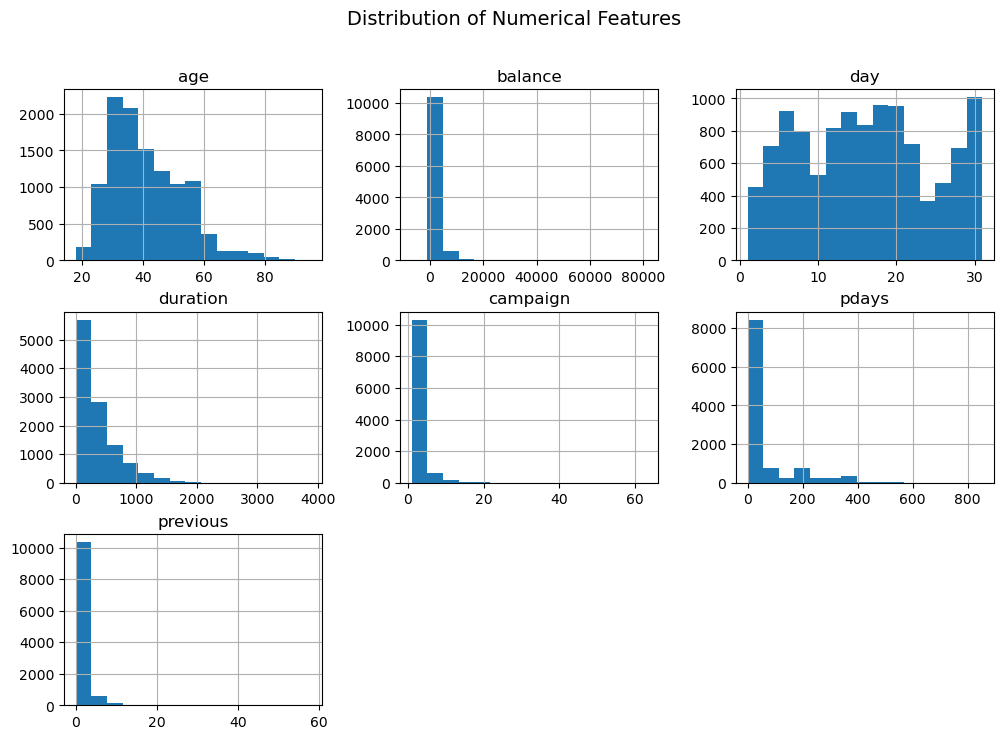

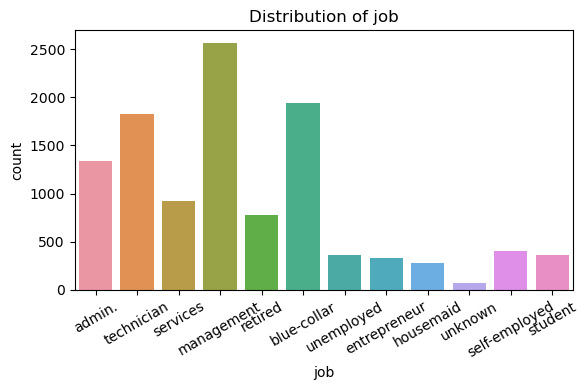

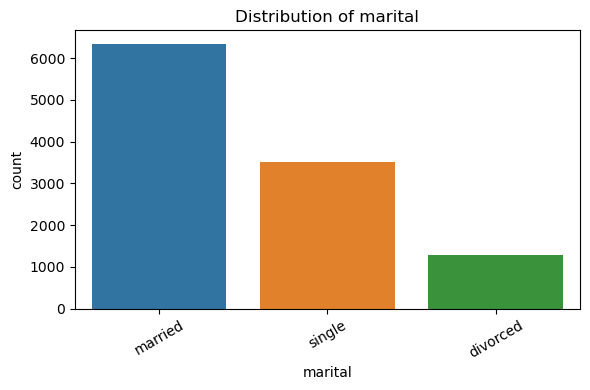

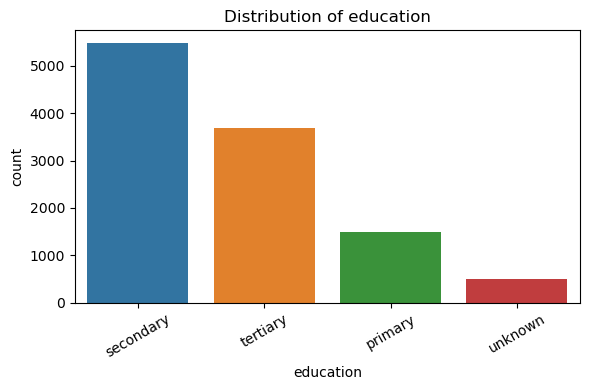

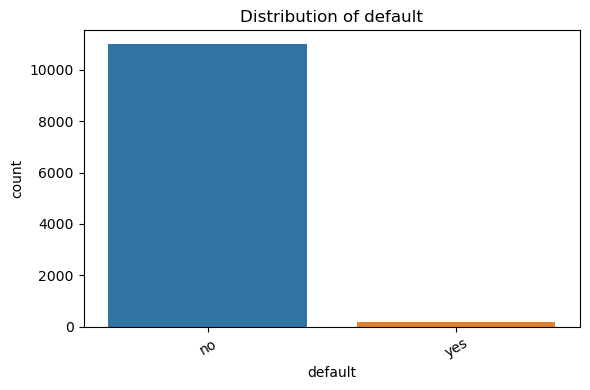

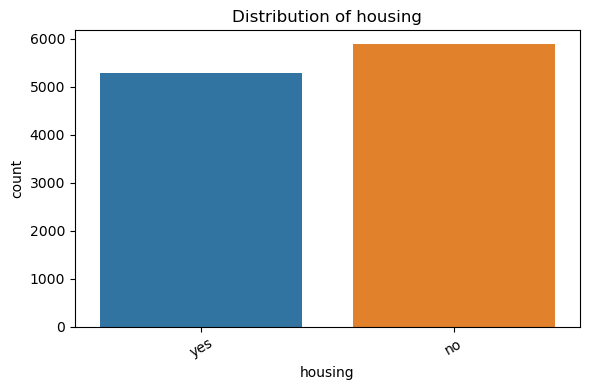

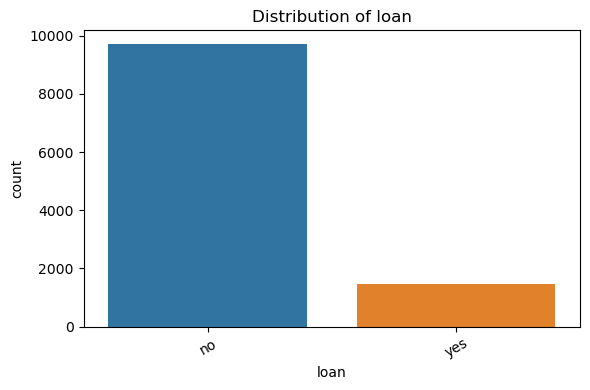

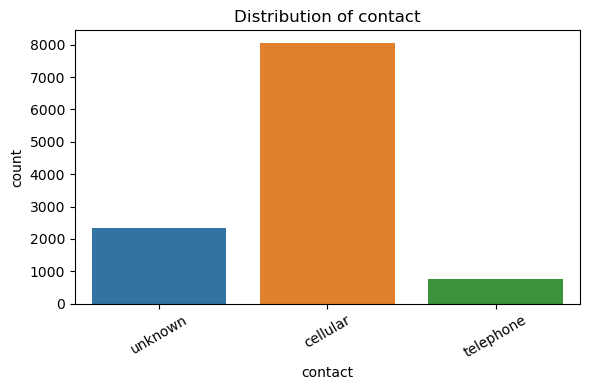

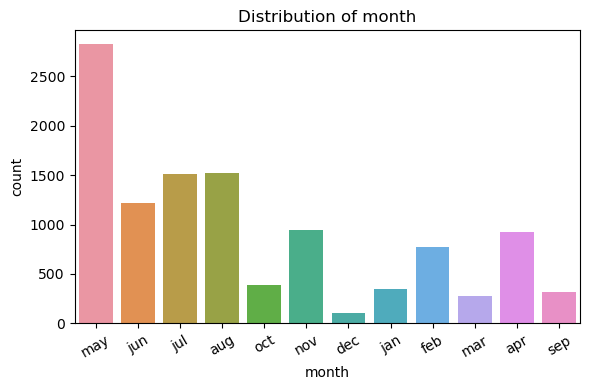

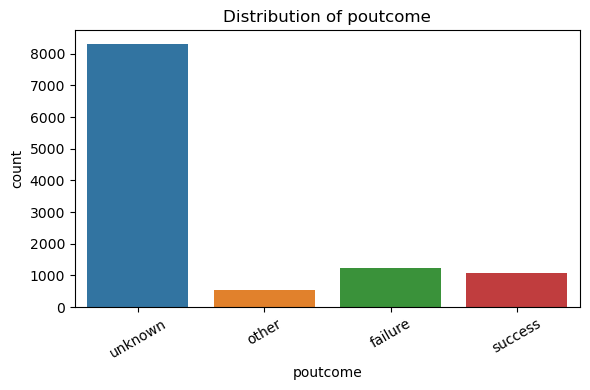

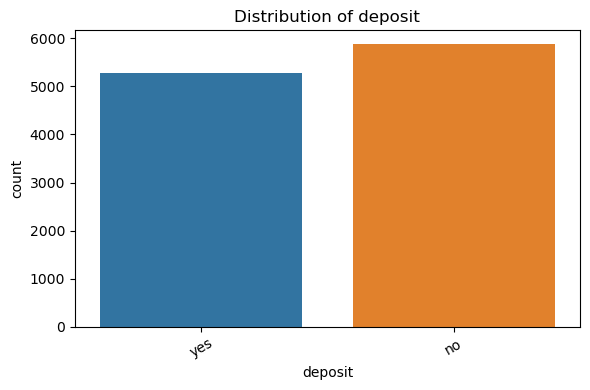

In [8]:
def univariate_analysis(data):
    # Plot distributions of numeric features
    numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns
    data[numeric_cols].hist(bins=15, figsize=(12,8))
    plt.suptitle("Distribution of Numerical Features", fontsize=14)
    plt.savefig("numerical_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Plot distributions of categorical features
    cat_cols = data.select_dtypes(include=["object"]).columns
    for col in cat_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=data)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=30)
        plt.tight_layout()
        # Optional: save each categorical distribution with a naming pattern
        plt.savefig(f"distribution_{col}.png", dpi=300, bbox_inches="tight")
        plt.show()

univariate_analysis(df)

In [10]:
def handle_outliers(data, cols_to_cap=None):
    if cols_to_cap is None:
        cols_to_cap = ['balance', 'duration', 'campaign', 'previous']
    
    for col in cols_to_cap:
        lower_bound = data[col].quantile(0.01)
        upper_bound = data[col].quantile(0.99)
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    return data

df_cleaned = handle_outliers(df.copy())

In [16]:
 class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])
        self.categorical_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])
        
        self.num_cols = ['age', 'balance', 'duration', 'campaign', 'previous']
        self.cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month']
        self.preprocessor = ColumnTransformer([
            ("num", self.numeric_transformer, self.num_cols),
            ("cat", self.categorical_transformer, self.cat_cols)
        ], remainder="drop")

    def fit(self, X, y=None):
        self.preprocessor.fit(X)
        return self

    def transform(self, X):
        return self.preprocessor.transform(X)


def preprocess_data(data):
    
    if 'day' in data.columns:
        data = data.drop(columns=['day'])

   
    if 'pdays' in data.columns:
        data['was_contacted'] = data['pdays'].apply(lambda x: 0 if x == -1 else 1)
        data.drop(columns=['pdays'], inplace=True)


    features = data.drop(columns=['deposit'])
    preproc = Preprocessor()
    X_processed = preproc.fit_transform(features)
    return X_processed

X = preprocess_data(df_cleaned)

In [18]:
X_dense = X.toarray()  
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

In [20]:
def find_optimal_clusters(X, max_k=10):
    inertia = []
    for k in range(1, max_k+1):
        kmeans_pca = KMeans(n_clusters=k, random_state=42)
        kmeans_pca.fit(X)
        inertia.append(kmeans_pca.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(range(1, max_k+1), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.savefig("elbow_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

    

C:\Users\ChazinBrahma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ChazinBrahma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ChazinBrahma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ChazinBrahma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

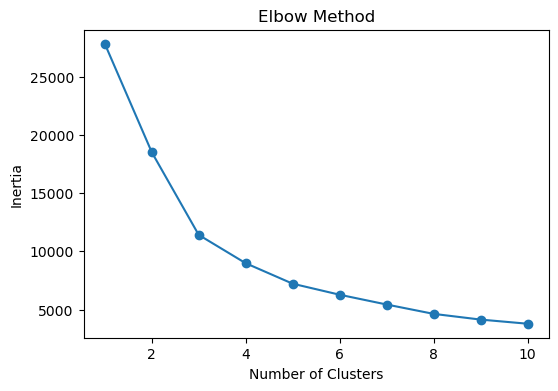

In [22]:
find_optimal_clusters(X_pca, max_k=10)

In [24]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters_pca = kmeans.fit_predict(X_pca)

df_cleaned['Cluster'] = clusters_pca


C:\Users\ChazinBrahma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:
numeric_cols = df_cleaned.select_dtypes(include=[int, float]).columns
numeric_summary = df_cleaned.groupby('Cluster')[numeric_cols].mean()
print("\nNumeric Summary by Cluster:\n", numeric_summary)


cat_cols = df_cleaned.select_dtypes(include=[object]).columns
categorical_summary = df_cleaned.groupby('Cluster')[cat_cols].agg(lambda x: x.mode()[0])
print("\nCategorical Summary by Cluster:\n", categorical_summary)



Numeric Summary by Cluster:
                age      balance        day    duration  campaign       pdays  \
Cluster                                                                        
0        34.794721   724.655099  15.806615  375.711235  2.485663   24.209677   
1        53.824625  2576.803339  16.002402  371.999333  2.667868   28.160961   
2        39.802243  1736.480307  14.442739  332.615525  1.786305  195.144628   

         previous  Cluster  
Cluster                     
0        0.128055      0.0  
1        0.244444      1.0  
2        4.171192      2.0  

Categorical Summary by Cluster:
                 job  marital  education default housing loan   contact month  \
Cluster                                                                        
0        management  married  secondary      no     yes   no  cellular   may   
1        management  married  secondary      no      no   no  cellular   aug   
2        management  married  secondary      no      no   no  cellular

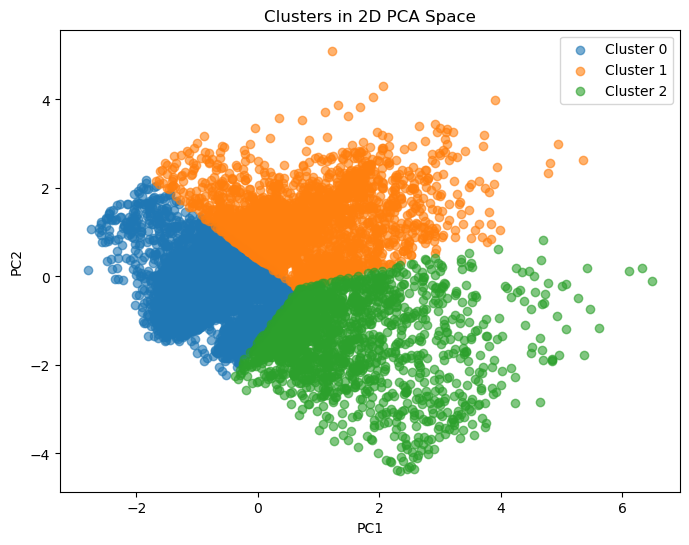

C:\Users\ChazinBrahma\AppData\Local\Temp\ipykernel_27704\438404436.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cluster', y='balance', data=df_cleaned, ci=None)


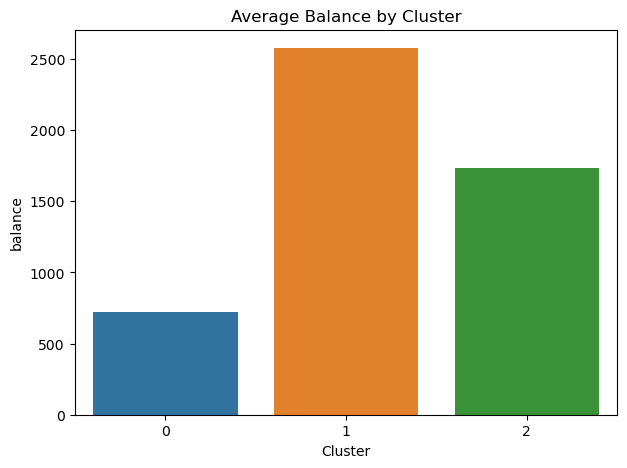

C:\Users\ChazinBrahma\AppData\Local\Temp\ipykernel_27704\438404436.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cluster', y='age', data=df_cleaned, ci=None)


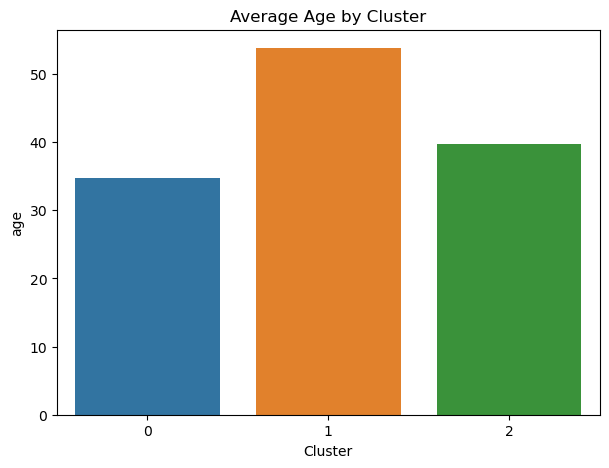

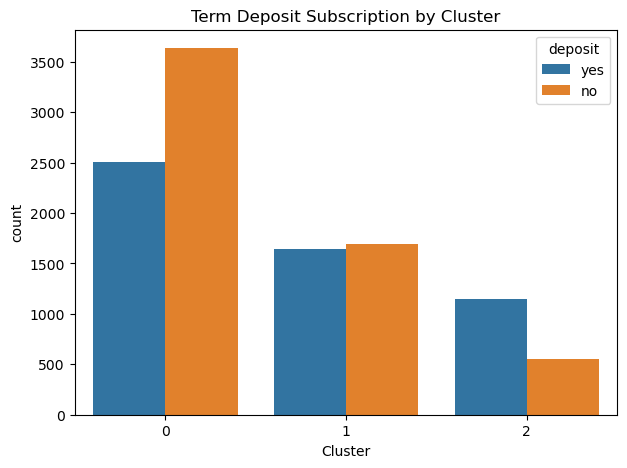

In [28]:
plt.figure(figsize=(8,6))
for cluster_label in np.unique(clusters_pca):
    plt.scatter(
        X_pca[clusters_pca == cluster_label, 0],
        X_pca[clusters_pca == cluster_label, 1],
        label=f"Cluster {cluster_label}",
        alpha=0.6
    )
plt.title("Clusters in 2D PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.savefig("pca_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

# 8.2 A few bar plots to interpret clusters
plt.figure(figsize=(7,5))
sns.barplot(x='Cluster', y='balance', data=df_cleaned, ci=None)
plt.title('Average Balance by Cluster')
plt.savefig("cluster_balance.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(7,5))
sns.barplot(x='Cluster', y='age', data=df_cleaned, ci=None)
plt.title('Average Age by Cluster')
plt.savefig("cluster_age.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(x='Cluster', hue='deposit', data=df_cleaned)
plt.title('Term Deposit Subscription by Cluster')
plt.savefig("cluster_deposit.png", dpi=300, bbox_inches="tight")
plt.show()


Silhouette Score: 0.425


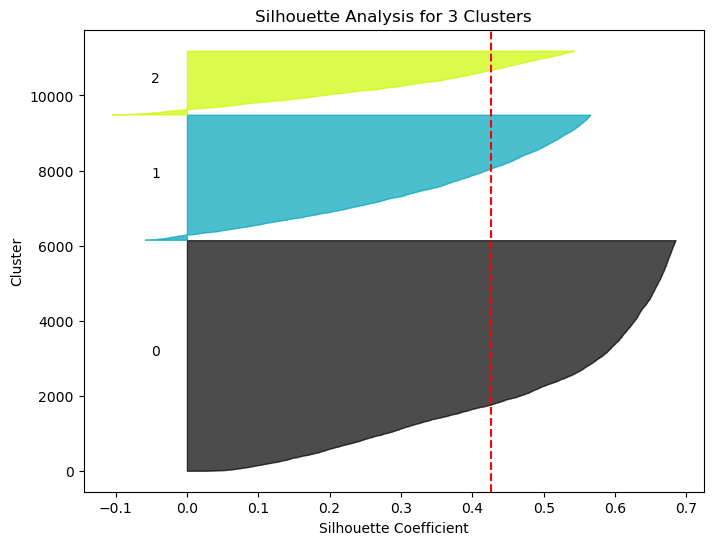

In [30]:
sil_score = silhouette_score(X_pca, clusters_pca)
print(f"\nSilhouette Score: {sil_score:.3f}")

sample_silhouette_values = silhouette_samples(X_pca, clusters_pca)


plt.figure(figsize=(8,6))
y_lower = 10
for i in range(optimal_k):
    ith_cluster_values = sample_silhouette_values[clusters_pca == i]
    ith_cluster_values.sort()
    size_cluster_i = ith_cluster_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=sil_score, color="red", linestyle="--")
plt.title(f"Silhouette Analysis for {optimal_k} Clusters")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.savefig("silhouette_plot.png", dpi=300, bbox_inches="tight")
plt.show()
